<a href="https://colab.research.google.com/github/rukmals/ColabProject/blob/master/vehicle_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

data = pd.read_csv('/content/sample_data/california_housing_test.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [2]:
from random import randint
import time

class Car:
    tracks=[]
    def __init__(self,i,xi,yi,max_age):
        self.i=i
        self.x=xi
        self.y=yi
        self.tracks=[]
        self.done=False
        self.state='0'
        self.age=0
        self.max_age=max_age
        self.dir=None

    def getTracks(self):
        return self.tracks

    def getId(self): #For the ID
        return self.i

    def getState(self):
        return self.state

    def getDir(self):
        return self.dir

    def getX(self):  #for x coordinate
        return self.x

    def getY(self):  #for y coordinate
        return self.y

    def updateCoords(self, xn, yn):
        self.age = 0
        self.tracks.append([self.x, self.y])
        self.x = xn
        self.y = yn

    def setDone(self):
        self.done = True

    def timedOut(self):
        return self.done

    def going_UP(self, mid_start, mid_end):
        if len(self.tracks)>=2:
            if self.state=='0':
                if self.tracks[-1][1]<mid_end and self.tracks[-2][1]>=mid_end:
                    state='1'
                    self.dir='up'
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def going_DOWN(self,mid_start,mid_end):
        if len(self.tracks)>=2:
            if self.state=='0':
                if self.tracks[-1][1]>mid_start and self.tracks[-2][1]<=mid_start:
                    start='1'
                    self.dir='down'
                    return True
                else:
                    return False
            else:
                return False
        else:
            return False

    def age_one(self):
        self.age+=1
        if self.age>self.max_age:
            self.done=True
        return  True

#Class2

class MultiCar:
    def __init__(self,cars,xi,yi):
        self.cars=cars
        self.x=xi
        self.y=yi
        self.tracks=[]
        self.done=False


Car counting and classification
448601.0


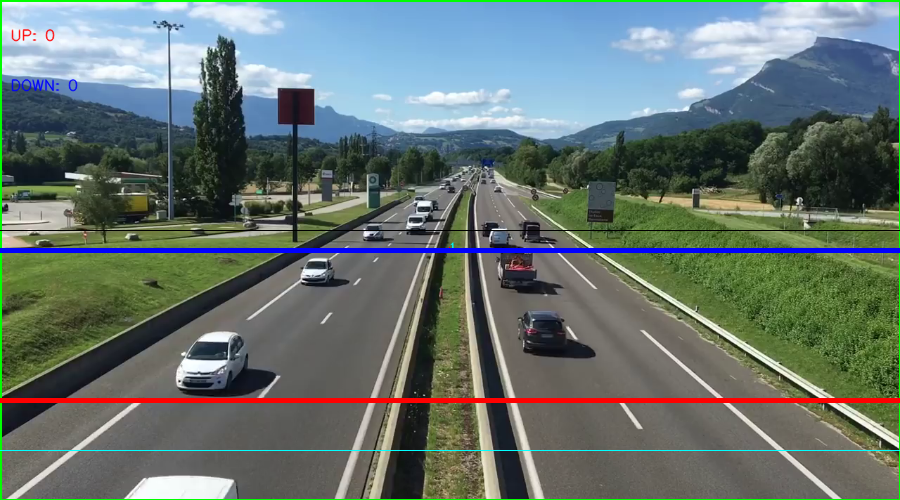

2338.5
26.5
5356.5
1031.0
10.0
183.5
643.5
18.0
540.5
6.0
73.5
29.0
6.0
16.0
8.5


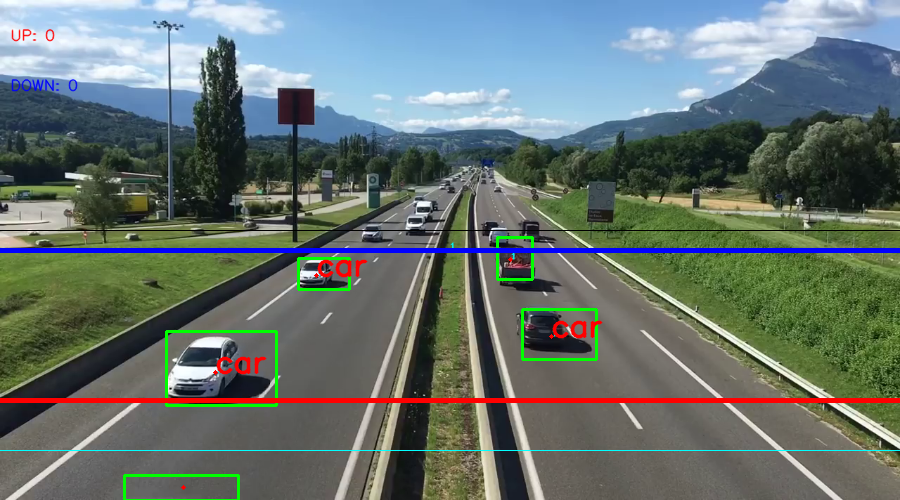

6.0
5548.5
456.0
312.5
92.5
73.0
419.5
55.0
4.0
24.0
20.0


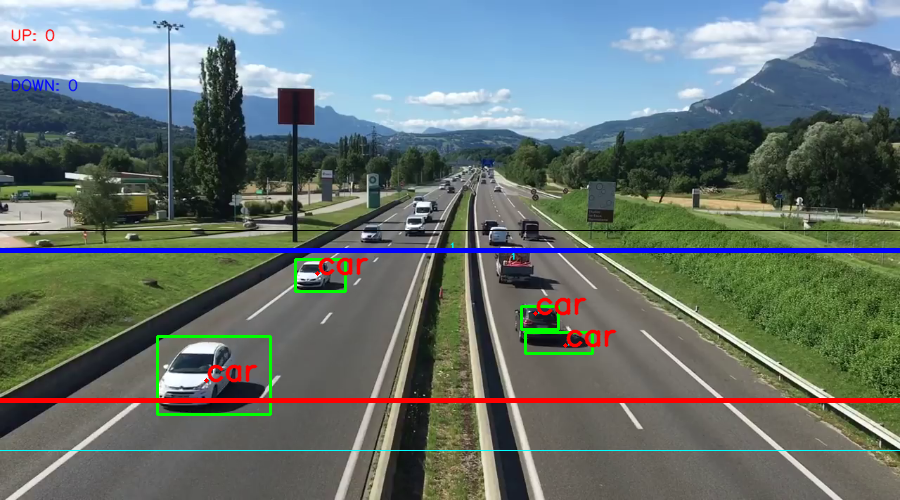

248.5
3498.0
4.0
412.5
4.0
8.0
192.5
65.0
16.0
4.0
222.0
30.0


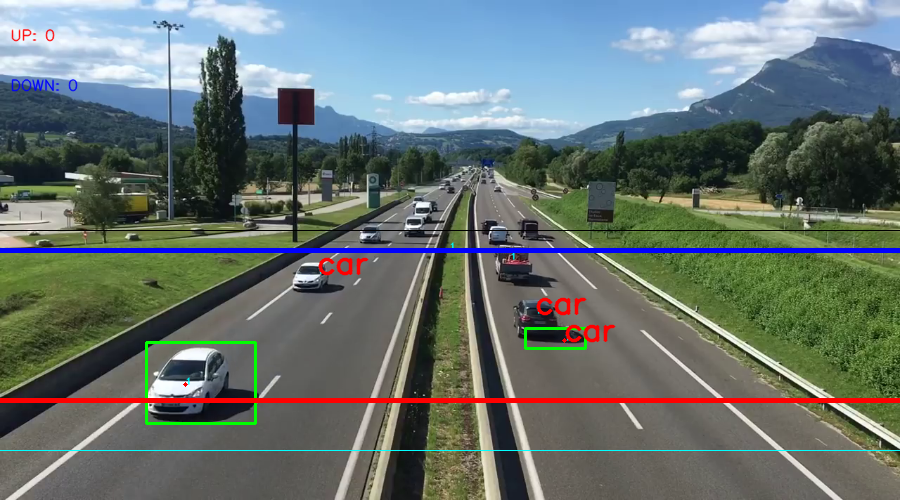

174.0
3441.0
6.0
328.0
227.5
6.0
94.5
632.0
4.0


In [ ]:
import cv2
import numpy as np
import time
from google.colab.patches import cv2_imshow
#import vehicles

cap=cv2.VideoCapture("/content/sample_data/video.mp4")
fgbg=cv2.createBackgroundSubtractorMOG2(detectShadows=False,history=200,varThreshold = 90)
kernalOp = np.ones((3,3),np.uint8)
kernalOp2 = np.ones((5,5),np.uint8)
kernalCl = np.ones((11,11),np.uint8)
font = cv2.FONT_HERSHEY_SIMPLEX
cars = []
max_p_age = 5
pid = 1
cnt_up=0
cnt_down=0

print("Car counting and classification")

line_up=400
line_down=250

up_limit=230
down_limit=int(4.5*(500/5))

while(cap.isOpened()):
    ret,frame=cap.read()
    frame=cv2.resize(frame,(900,500))
    for i in cars:
        i.age_one()
    fgmask=fgbg.apply(frame)

    if ret==True:
        ret,imBin=cv2.threshold(fgmask,200,255,cv2.THRESH_BINARY)
        mask = cv2.morphologyEx(imBin, cv2.MORPH_OPEN, kernalOp)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernalCl)


        (countours0,hierarchy)=cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)
        for cnt in countours0:
            area=cv2.contourArea(cnt)
            print(area)
            if area>300:

                m=cv2.moments(cnt)
                cx=int(m['m10']/m['m00'])
                cy=int(m['m01']/m['m00'])
                x,y,w,h=cv2.boundingRect(cnt)


                new=True
                if cy in range(up_limit,down_limit):
                    for i in cars:
                        if abs(x - i.getX()) <= w and abs(y - i.getY()) <= h:
                            new = False
                            i.updateCoords(cx, cy)

                            if i.going_UP(line_down,line_up)==True:
                                cnt_up+=1

                            elif i.going_DOWN(line_down,line_up)==True:
                                cnt_down+=1

                            break
                        if i.getState()=='1':
                            if i.getDir()=='down'and i.getY()>down_limit:
                                i.setDone()
                            elif i.getDir()=='up'and i.getY()<up_limit:
                                i.setDone()
                        if i.timedOut():
                            index=cars.index(i)
                            cars.pop(index)
                            del i

                    if new==True:
                        p=Car(pid,cx,cy,max_p_age)
                        cars.append(p)
                        pid+1
                cv2.circle(frame, (cx, cy), 2, (0, 0, 255), -1)



                img=cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)






        for i in cars:
            cv2.putText(frame, str(i.getId()), (i.getX(), i.getY()), font, 0.3, (255,255,0), 1, cv2.LINE_AA)
            if line_down+20<= i.getY() <= line_up-20:
               a = (h + (.74*w)- 100)

               if a >= 0:
                     cv2.putText(frame, "Truck", (i.getX(), i.getY()), font, 1, (0,0,255), 2, cv2.LINE_AA)
               else:
                     cv2.putText(frame, "car", (i.getX(), i.getY()), font, 1, (0,0,255), 2, cv2.LINE_AA)


        str_up='UP: '+str(cnt_up)
        str_down='DOWN: '+str(cnt_down)
        frame=cv2.line(frame,(0,line_up),(900,line_up),(0,0,255),3,8)
        frame=cv2.line(frame,(0,up_limit),(900,up_limit),(0,0,0),1,8)

        frame=cv2.line(frame,(0,down_limit),(900,down_limit),(255,255,0),1,8)
        frame = cv2.line(frame, (0, line_down), (900, line_down), (255, 0,0), 3, 8)




        cv2.putText(frame, str_up, (10, 40), font, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
        cv2.putText(frame, str_down, (10, 90), font, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
        #cv2.imshow('Frame',frame)
        cv2_imshow(frame)

        if cv2.waitKey(1)&0xff==ord('q'):
            break

    else:
        break

cap.release()
cv2.destroyAllWindows()
